# Getting Started with the Arize Platform - Investigating Prediction Drift

**In this walkthrough, we are going to investigate prediction drift and get to the bottom of why it happened.**

You manage the fraud detection model for the widely used [Lending Club](https://www.lendingclub.com/). One day you're alerted to a huge spike in the number of fraudulent loans that are slipping through your system! Realizing you have no way of investigating this, you turn to Arize to monitor and observe what changed in your previously working fraud detection model.

Our steps to resolving this issue will be :

1. Get our model onto the Arize platform to investigate
2. Setup drift monitors and identify prediction drift
3. Figure out which features are drifting and causing the prediction drift

# Step 0. Setup and Getting the Data
We will load in some preexisting data for the Lending Club fraud detection model - training data, test data, and predictions. Using the preexisting model saves time in this example and also illustrates how simple it is to plug into the Arize platform.
###Install Dependencies and Import Libraries 📚

In [ ]:
!pip install -q arize

import pandas as pd
from arize.utils.types import ModelTypes, Environments
from arize.pandas.logger import Client, Schema
import datetime

# Preparing dataset for this tutorial
datasets = {}
url = "https://storage.googleapis.com/arize-assets/fixtures/value_showcase"
for env in ["training", "validation", "production", "shap"]:
    datasets[env] = pd.read_csv(f"{url}/{env}.zip")

datasets["production"]["model_date"] = pd.to_datetime(datasets["production"]["model_date"])
shap_df = datasets["shap"]

print("✅ Dependencies installed and data successfully downloaded!")

# Step 1. Sending Data into Arize 💫

Now that we have our data configured, we are ready to integrate into Arize. We do this by logging (sending) important data we want to analyze to the platform. There, the data will be easily visualized and investigated to source our problem.

For our model, we are going to log:


*   feature data
*   predictions
*   actuals
*   SHAP values for explainability metrics

## Import and Setup Arize Client

The first step is to setup our Arize client. After that we will log the data.

First, copy the Arize `API_KEY` and `SPACE_KEY` from your admin page shown below! Copy those over to the set-up section. We will also be setting up some metadata to use across all logging.






<img src="https://storage.googleapis.com/arize-assets/fixtures/copy-keys.png" width="700">

In [ ]:
SPACE_KEY = "SPACE_KEY"
API_KEY = "API_KEY"
arize_client = Client(space_key=SPACE_KEY, api_key=API_KEY)

model_id = "analyze-prediction-drift"  # This is the model name that will show up in Arize
model_version = "v1.0"  # Version of model - can be any string
model_type = ModelTypes.SCORE_CATEGORICAL

if SPACE_KEY == "SPACE_KEY" or API_KEY == "API_KEY":
    raise ValueError("❌ NEED TO CHANGE SPACE AND/OR API_KEY")
else:
    print("✅ Arize setup complete!")

## Log Training & Validation Data
Now that our Arize client is setup, let's go ahead and log all of our data to the platform. For more details on how **`arize.pandas.logger`** works, visit out documentations page below.

[![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/Buttons_OpenOrange.png)](https://docs.arize.com/arize/sdks-and-integrations/python-sdk/arize.pandas)

In [ ]:
# This is the data which we will be logging
val_df = datasets["validation"]
train_df = datasets["training"]
feature_column_names = ["loan_amount", "term", "interest_rate", "installment", "grade", "home_ownership", "annual_income",
                        "verification_status", "pymnt_plan", "purpose", "addr_state", "dti", "delinq_2yrs", "inq_last_6mths", "mths_since_last_delinq",
                        "mths_since_last_record", "open_acc", "pub_rec", "revol_bal", "revol_util","total_acc", "fico_score", "fico_range"
                        ]

# Define a Schema() object for Arize to pick up data from the correct columns for logging
schema = Schema(
    prediction_id_column_name="prediction_ids",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    # feature_column_names should be specific to your model
    feature_column_names=feature_column_names,
)

# Logging Training DataFrame
train_response = arize_client.log(
    dataframe=datasets["training"],
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.TRAINING,
    schema=schema,
)

# Logging Validation DataFrame
val_response = arize_client.log(
    dataframe=datasets["validation"],
    model_id=model_id,
    model_version=model_version,
    batch_id="val",
    model_type=model_type,
    environment=Environments.VALIDATION,
    schema=schema,
)

# If successful, the server will return a status_code of 200
if val_response.status_code != 200 or train_response.status_code != 200:
    print(f"❌ logging failed with response code {train_response.status_code}, {train_response.text}")
    print(f"❌ logging failed with response code {val_response.status_code}, {val_response.text}")
else:
    print(f"✅ You have successfully logged validation set to Arize")

## Log the Production Data
Similarly, we will use the `arize.pandas.logger` to log the production dataset. Here, we will need to add 
1. A `prediction_ts` column to our DataFrame and a `timestamp_column_name` argument to our schema to set time for our model.
2. A `feature_name_shap` column for each feature, as well as a dictionary mapping names of features column names to their shap column names.

In [ ]:
# We need to redefine schema since we added prediction_ts column for production timeline
time_offset = datetime.datetime.now() - datasets['production']["model_date"].max()
datasets['production']["prediction_ts"] = datasets['production']["model_date"].apply(lambda t: (t + time_offset).timestamp())

# We also need to log SHAP values, so we need to insert the shap columns into our df for pandas logger 
shap_values_column_names = {} # k-v mapping 'feature_name' to 'feature_name_shap' in df
for column_name in shap_df.columns:
    shap_column_name = column_name + '_shap'
    # Creating a mapping from feature column name to shap column name for Schema()
    shap_values_column_names[column_name] = shap_column_name
    # Adding the shap content to our production_df 
    datasets['production'][shap_column_name] = shap_df[column_name]

# Define a Schema() object for Arize to pick up data from the correct columns for logging
production_schema = Schema(
    prediction_id_column_name="prediction_ids",
    feature_column_names=feature_column_names,
    timestamp_column_name="prediction_ts",
    prediction_label_column_name="predictions",
    prediction_score_column_name="predictions_score",
    actual_label_column_name="actuals",
    shap_values_column_names=shap_values_column_names
)

# arize_client.log returns a Response object from Python's requests module
prod_response = arize_client.log(
    dataframe=datasets["production"],
    model_id=model_id,
    model_version=model_version,
    model_type=model_type,
    environment=Environments.PRODUCTION,
    schema=production_schema,
)

# If successful, the server will return a status_code of 200
if prod_response.status_code != 200:
    print(f"❌ logging failed with response code {response.status_code}, {response.text}")
else:
    print(f"✅ You have successfully logged production set to Arize")

## Check Data Ingestion Information

Data will be available in the UI in about 10 minutes after it was received. If data from a new model is sent, the model will be reflected almost immediately in the Arize platform. However, you will not see data yet. To verify data has been sent correctly and is being processed, we recommend that you check our Data Ingestion tab. 

You will be able to see the predictions, actuals, and feature importances that have been sent in the last week, last day or last 30 minutes. 

An example view of the Data Ingestion tab from a model, when data is sent continuously over 30 minutes, is shown in the image below. 

<img src="https://storage.googleapis.com/arize-assets/fixtures/data-ingestion-tab.png" width="700">

# Coffee Time! ☕️
Note that the Arize performs takes about 10 minutes to index the data. While the model should appear immediately, the data will not show up till the indexing is done. Feel free to go grab a cup of coffee as Arize works its magic! 🔮

**⚠️ DON'T SKIP:**
In order to move on to the next step, make sure your actuals and training/validation sets are loaded into the platform. To check:
1. On the **Overview Tab** make sure you see the actuals as shown below.
2. Actual data will show up under **Model Health**. Once the number changes from **0 Actuals** to **Actuals** (with summary statistics such as cardinality listed in the drop-down), your production actuals will have been fully recorded on Arize!

![image.png](https://storage.googleapis.com/arize-assets/fixtures/waiting-on-data.png)

![image.png](https://storage.googleapis.com/arize-assets/fixtures/waiting-on-actual-data.png)

# **Step 2. Analyze Prediction Drift**
Welcome back! Now we can go take a look at the [Arize platform](https://app.arize.com/) and take a look at the logged data to begin our investigation into the poorly performing fraud detection. Head over to the **Models** page and select our newly created model `analyze-prediction-drift`.
### **Setting up a Baseline**

In order to get a drift metric at all, we first need to set up a baseline to compare our model to. Go ahead and click on the **Configure** button in the bottom popup, or by going to the **Baseline** button on the right side of the screen. 

We're going to set the **training data** as our baseline to compare our model to. Click on **Config** on top right and follow the below guide to set up this baseline.

![configure-baseline.gif](https://storage.googleapis.com/arize-assets/fixtures/configure-baseline-v2.gif)

### **Creating Drift Monitors**
Now that we have our baseline configured, we can look at metrics such as **Drift (PSI)**. Take a quick look at the **Model Health** section for the prediction drift score. Notice how it's quite high and a red warning icon is displayed next to it.

Let's start our investigation of this drift issue by creating **Drift Monitors** for predictions and all features. You can create all of them in one click by pressing on the plus button next to *Drift*. This helps you quickly navigate to important features in the future.

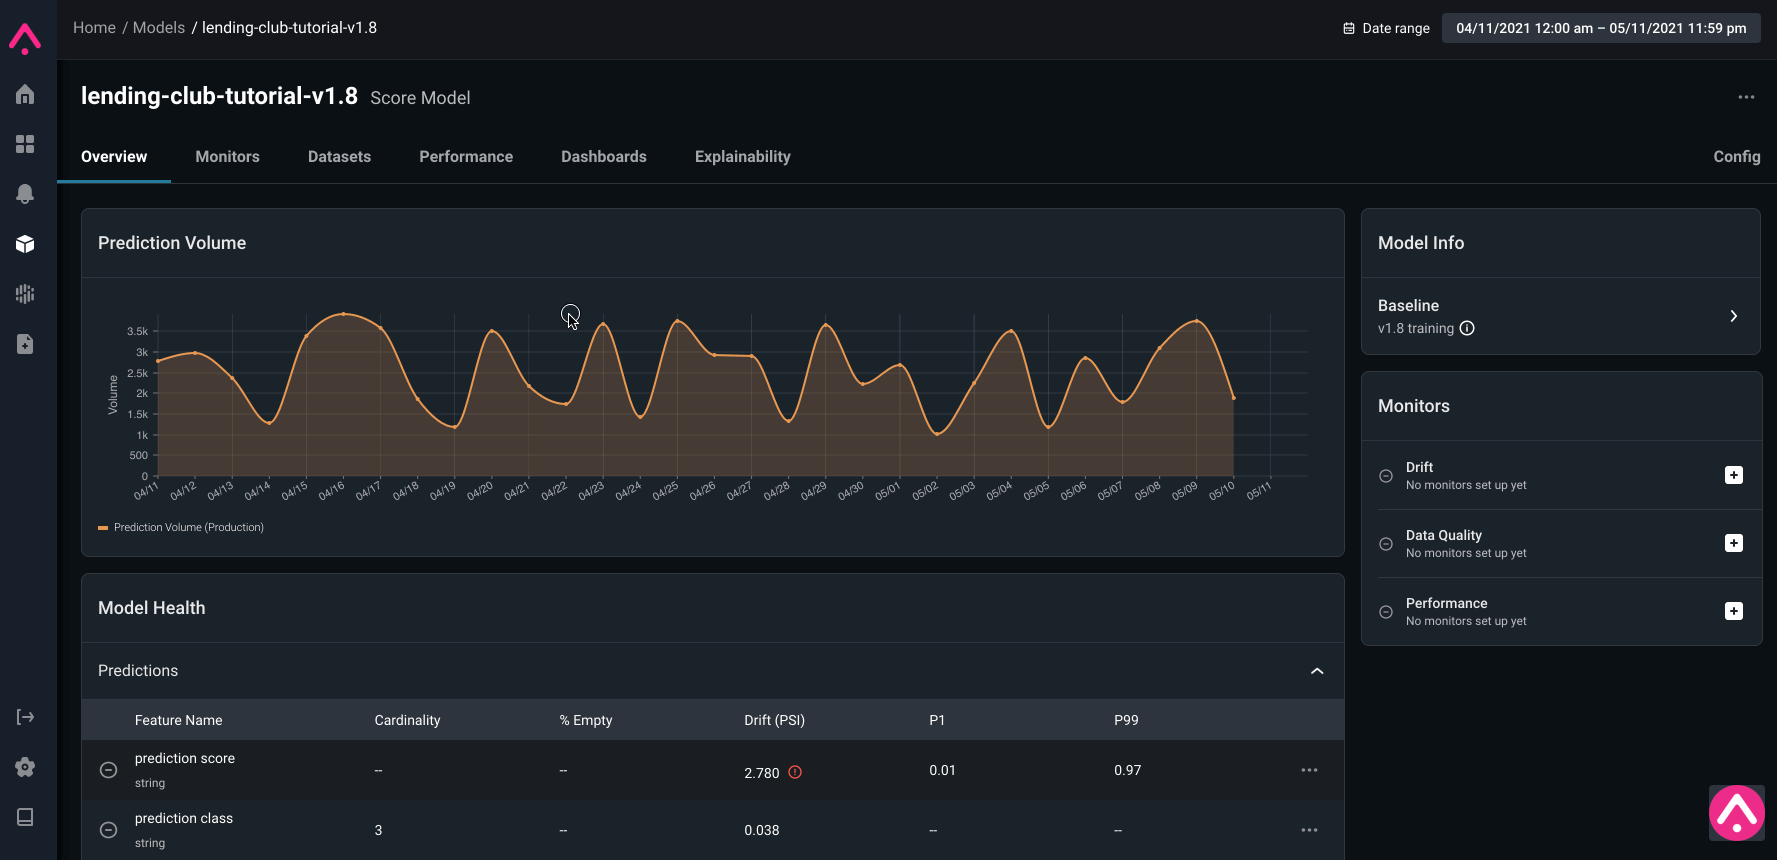

## **Using The Drift Tab**
Each model has its own Drift Tab: a central hub that includes many tools to help you monitor model performance and data distribution shifts. It offers a deep drive into Prediction Drift, Feature Drift, and Data Distribution Change.

You can navigate to it by clicking on Drift for any model!
![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/drift-nav.png)


### **For more details about the Drift Tab, visit our documentations page**

[![Buttons_OpenOrange.png](https://storage.googleapis.com/arize-assets/fixtures/Buttons_OpenOrange.png)](https://arize.gitbook.io/arize/platform-features/drift-tab)

## **Investigating Prediction Drift**

Now let's click into the Drift Tab and take a look at the data. Immediately, you can tell the model is way past the PSI threshold under **Prediction Drift**.

You can click different points on the Prediction Drift curve to surface actual distribution and feature drifts for each day. Clearly, there is a dangerous upwards trend in prediction drift!


![distribution-change.gif](https://storage.googleapis.com/arize-assets/fixtures/distribution-change.gif)


Looking at the distribution chart below the line chart, it looks as if our model is predicting a lot less fraud than it used to! This must be why our why are seeing so many more fraudulent cases slip through - the question is, why did the prediction drift?

# **Step 3. Analyze Feature Drift**
Let's explore what could be causing this prediction drift. One potential source is individual feature drifts. **In the Drift Tab, scroll down to Feature Drift** and take a look at the which features are causing the most amount of Prediction Drift Impact.


![distribution-change.gif](https://storage.googleapis.com/arize-assets/fixtures/feature-drift-showcase.gif)

It looks a number of other features exhibit fairly high drift values. Let's take a look at the `annual_income` which has the highest PSI. Click the monitor icon on the `annual income` row to go into its drift monitor page.


## **The Drift Monitor**

This monitor view allows you to see both the drift over time, as well as the difference between the current and baseline distribution. As you can see, there is a huge ramp-up in drift for the `annual_income` feature.

![drift-monitor.gif](https://storage.googleapis.com/arize-assets/fixtures/drift-monitor.gif)

With this information, it seems quite possible that an increase in feature drift for `annual_income` and perhaps a number of other features is responsible for our prediction drift. Thus, it seems as if this feature drift is causing our original problem of missing real fraud cases!

# Wrap Up 🎁

In this walkthrough we've shown how Arize can be used to log prediction data for a model, discover prediction and feature drift, and set up monitors to catch future issues. Though we covered a lot of ground, this is just scratching the surface of what the Arize platform can do. We urge you to explore more of Arize, either on your own or through one of our many other tutorials.

### Overview
Arize is an end-to-end ML observability and model monitoring platform. The platform is designed to help ML engineers and data science practitioners surface and fix issues with ML models in production faster with:
- Automated ML monitoring and model monitoring
- Workflows to troubleshoot model performance
- Real-time visualizations for model performance monitoring, data quality monitoring, and drift monitoring
- Model prediction cohort analysis
- Pre-deployment model validation
- Integrated model explainability

### Website
Visit Us At: https://arize.com/model-monitoring/

### Additional Resources
- [What is ML observability?](https://arize.com/what-is-ml-observability/)
- [Playbook to model monitoring in production](https://arize.com/the-playbook-to-monitor-your-models-performance-in-production/)
- [Using statistical distance metrics for ML monitoring and observability](https://arize.com/using-statistical-distance-metrics-for-machine-learning-observability/)
- [ML infrastructure tools for data preparation](https://arize.com/ml-infrastructure-tools-for-data-preparation/)
- [ML infrastructure tools for model building](https://arize.com/ml-infrastructure-tools-for-model-building/)
- [ML infrastructure tools for production](https://arize.com/ml-infrastructure-tools-for-production-part-1/)
- [ML infrastructure tools for model deployment and model serving](https://arize.com/ml-infrastructure-tools-for-production-part-2-model-deployment-and-serving/)
- [ML infrastructure tools for ML monitoring and observability](https://arize.com/ml-infrastructure-tools-ml-observability/)

Visit the [Arize Blog](https://arize.com/blog) and [Resource Center](https://arize.com/resource-hub/) for more resources on ML observability and model monitoring.
